## Comparing signatures images using classical algorithms

In this notebook we use classical algorithms as, Difference, Mean Squared Error (MSE) and Structural Similarity Measure (SSM) for measuring how similar a pair of images are.

We are using a data set with 10019 triplets. Each triplet is maded for a anchor, a positive and a negative image signature. 

**References:**   
https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/   
https://scikit-image.org/docs/dev/api/skimage.measure.html

In [17]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

from skimage import measure

from matplotlib import pyplot as plt

print( "cv2 version:", cv2.__version__ )

cv2 version: 4.1.0


## Loading dataset

In [18]:
sample_signatures_df = pd.read_csv( '../dataset/signatures/X_test.csv' )
print(sample_signatures_df.shape)
sample_signatures_df.head()

(10019, 3)


,Anchor,Positive,Negative
0,original_45_3.png,original_45_19.png,forgeries_45_19.png
1,original_37_18.png,original_37_15.png,forgeries_37_15.png
2,original_24_11.png,original_24_24.png,forgeries_24_24.png
3,original_33_20.png,original_33_3.png,forgeries_33_3.png
4,original_2_9.png,original_2_22.png,forgeries_2_22.png


## Auxiliary methods

In [19]:
def processing_image( image_path ):
    
    # Read image as grayscale
    image = cv2.imread( image_path, cv2.IMREAD_GRAYSCALE )
    
    # Binarize image through Otsu's thresholding. 
    # Background will be back and signature will be white.
    _, image_bin = cv2.threshold( image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    
    # Compute signature bounding box
    points = cv2.findNonZero( image_bin )
    x, y, w, h = cv2.boundingRect( points )
    
    # Crop image according to boundingbox
    proc_image = image_bin[y:y+h, x:x+w]
    
    return proc_image

In [20]:
def resize_key_imge( key_image, image ):
    h, w = image.shape[:2]
    return cv2.resize( key_image.copy(), (w, h) )

In [21]:
def compute_diff( image_x, image_y ):
    img_diff = np.absolute( image_x - image_y )
    return img_diff.sum() / img_diff.size

In [22]:
def compute_measures( img, sample ):
    mse = measure.compare_mse( img, sample )
    ssim = measure.compare_ssim( img, sample )
    diff = compute_diff( img, sample )
    return mse, ssim, diff

In [23]:
def saving_results( df, anchor, positive, negative, pos_mse, neg_mse, pos_ssim, 
                    neg_ssim, pos_diff, neg_diff ):

    df = df.append( {'Anchor'   : anchor, 
                     'Positive' : positive,
                     'Negative' : negative,
                     'Pos-MSE'  : pos_mse, 
                     'Neg-MSE'  : neg_mse,                 
                     'Pos-SSIM' : pos_ssim, 
                     'Neg-SSIM' : neg_ssim,
                     'Pos-DIFF' : pos_diff, 
                     'Neg-DIFF' : neg_diff
                    }, ignore_index=True )
    return df

## Computing measures for signatures

In [24]:
results_df = pd.DataFrame( columns = ['Anchor', 'Positive', 'Negative', 
                                      'Pos-MSE',  'Neg-MSE', 
                                      'Pos-SSIM', 'Neg-SSIM',
                                      'Pos-DIFF', 'Neg-DIFF'] )

genuine_signatures_path =  "../dataset/signatures/full_org/"
forged_signatures_path = "../dataset/signatures/full_forg/"

for index, row in tqdm( sample_signatures_df.iterrows() ): 
    
    anchor   = processing_image( genuine_signatures_path + row["Anchor"]   )
    positive = processing_image( genuine_signatures_path + row["Positive"] )
    negative = processing_image( forged_signatures_path  + row["Negative"] )
           
    # Making orignal signatures to the same size and computing measures
    positive = resize_key_imge( positive, anchor )
    pos_mse, pos_ssim, pos_diff = compute_measures( anchor, positive )
        
    # Making original and fake signatures to the same size and computing measures
    negative = resize_key_imge( negative, anchor )
    neg_mse, neg_ssim, neg_diff = compute_measures( anchor, negative )
        
    # Saving results on dataframe
    results_df = saving_results( results_df, row["Anchor"] , row["Positive"], row["Negative"], 
                                pos_mse, neg_mse, pos_ssim, neg_ssim, pos_diff, neg_diff )

10019it [11:16, 20.34it/s]


In [25]:
results_df.head()

,Anchor,Positive,Negative,Pos-MSE,Neg-MSE,Pos-SSIM,Neg-SSIM,Pos-DIFF,Neg-DIFF
0,original_45_3.png,original_45_19.png,forgeries_45_19.png,5588.379274,4340.799234,0.777746,0.804608,13.555016,13.703727
1,original_37_18.png,original_37_15.png,forgeries_37_15.png,4510.534031,4073.482055,0.774235,0.793931,13.535334,12.092570
2,original_24_11.png,original_24_24.png,forgeries_24_24.png,7742.254214,5986.971231,0.666489,0.683065,17.678195,16.582469
3,original_33_20.png,original_33_3.png,forgeries_33_3.png,8797.857000,7044.113108,0.618207,0.653824,23.763392,21.475090
4,original_2_9.png,original_2_22.png,forgeries_2_22.png,7445.584172,10111.483064,0.661353,0.575846,21.249801,24.830718


In [26]:
results_df.describe()

,Pos-MSE,Neg-MSE,Pos-SSIM,Neg-SSIM,Pos-DIFF,Neg-DIFF
count,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000
mean,7039.810153,7111.320916,0.680507,0.667973,19.660967,20.315106
std,2504.794728,2232.973089,0.102057,0.099414,6.996541,7.136930
min,2076.925946,2311.475202,0.367628,0.363890,6.159959,6.031249
25%,4954.509563,5333.807801,0.601499,0.592427,13.938886,14.572514
50%,6789.764740,6974.110569,0.691556,0.675811,18.655609,19.322599
75%,8933.978417,8746.738390,0.763579,0.746493,24.824463,25.579388
max,15484.736135,14468.956101,0.886692,0.888259,43.350084,44.856583


In [27]:
results_df = results_df.round(0)
results_df.head()

,Anchor,Positive,Negative,Pos-MSE,Neg-MSE,Pos-SSIM,Neg-SSIM,Pos-DIFF,Neg-DIFF
0,original_45_3.png,original_45_19.png,forgeries_45_19.png,5588.0,4341.0,1.0,1.0,14.0,14.0
1,original_37_18.png,original_37_15.png,forgeries_37_15.png,4511.0,4073.0,1.0,1.0,14.0,12.0
2,original_24_11.png,original_24_24.png,forgeries_24_24.png,7742.0,5987.0,1.0,1.0,18.0,17.0
3,original_33_20.png,original_33_3.png,forgeries_33_3.png,8798.0,7044.0,1.0,1.0,24.0,21.0
4,original_2_9.png,original_2_22.png,forgeries_2_22.png,7446.0,10111.0,1.0,1.0,21.0,25.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5ABA0FF60>,
      dtype=object)

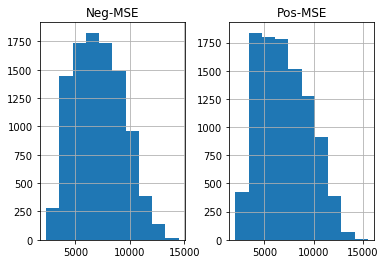

In [37]:
mse = results_df[ ['Pos-MSE', 'Neg-MSE'] ]
mse.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5ABF7F6D8>,
      dtype=object)

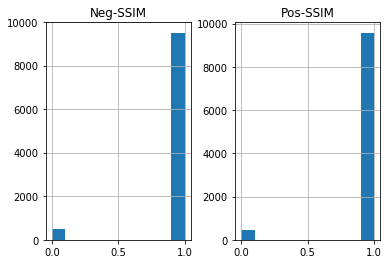

In [38]:
ssim = results_df[ ['Pos-SSIM', 'Neg-SSIM'] ]
ssim.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5AB6C8B70>,
      dtype=object)

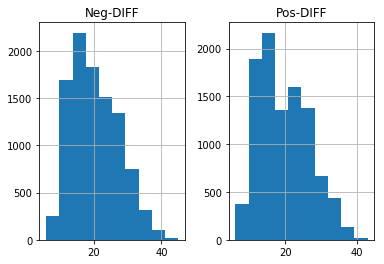

In [41]:
diff = results_df[ ['Pos-DIFF', 'Neg-DIFF'] ]
diff.hist()